In [39]:
import torch
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [40]:
mnist_dataset_train = MNIST('train', True, download=True)
mnist_dataset_test = MNIST('test', False, download=True)

In [41]:
len(mnist_dataset_train), len(mnist_dataset_test)

(60000, 10000)

In [42]:
mnist_dataset_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

/tmp/ipykernel_11410/3058727472.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


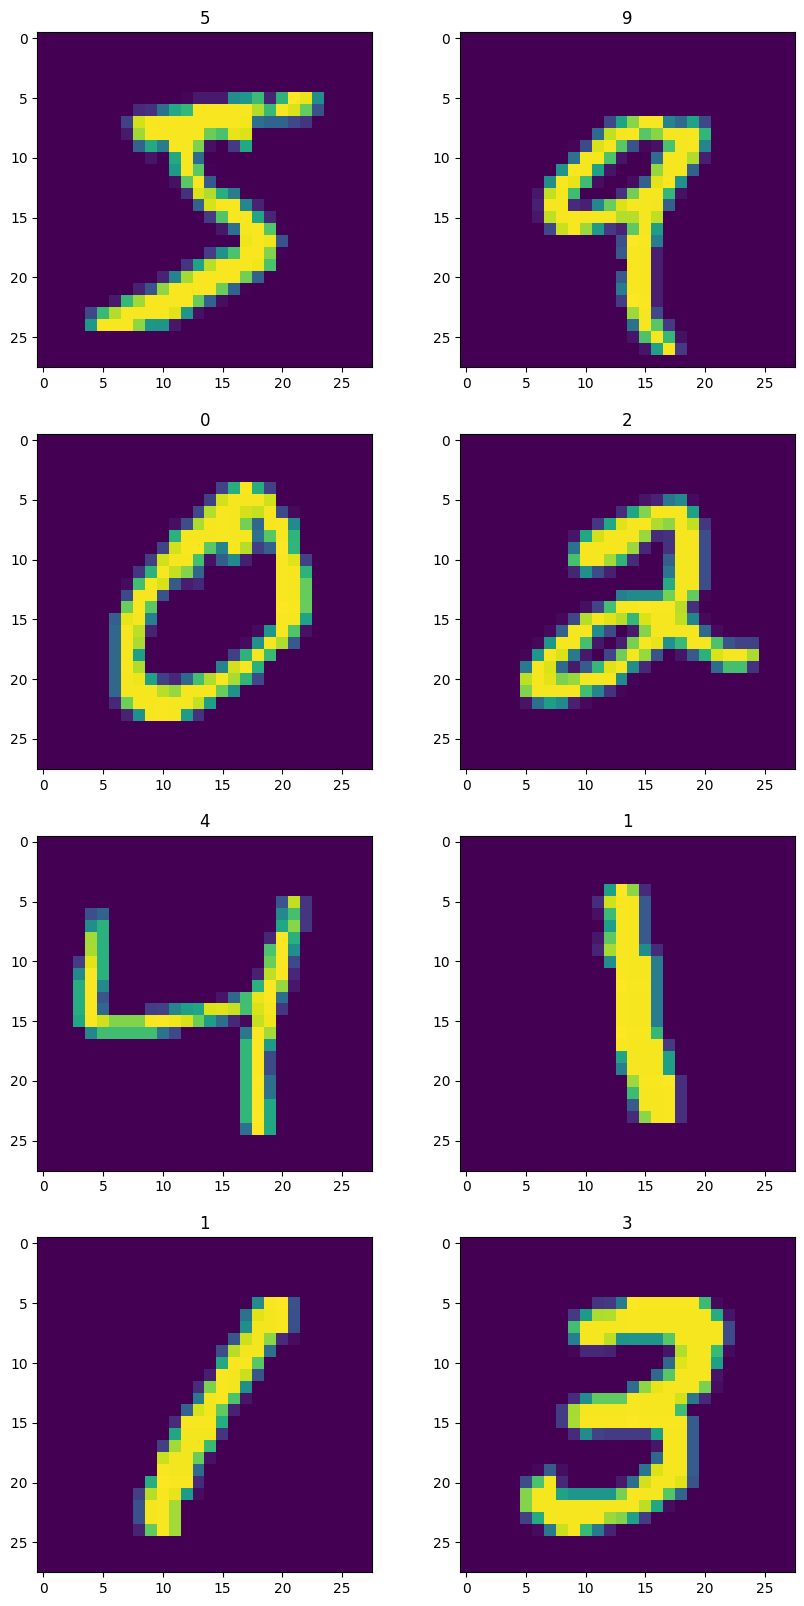

In [43]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

for idx, (x, y) in enumerate(mnist_dataset_train):
    ax = axs[idx % 4][idx // 4]
    ax.imshow(x)
    ax.set_title(y)
    if idx == 7:
      break
fig.show()

In [44]:
np.array(mnist_dataset_train[0][0]).reshape(784).shape

(784,)

In [45]:
np.array([el[1] for el in mnist_dataset_train])

array([5, 0, 4, ..., 5, 6, 8])

In [46]:
X_train = np.array([np.array(el[0]).flatten() for el in mnist_dataset_train])
y_train = np.array([el[1] for el in mnist_dataset_train])
X_test = np.array([np.array(el[0]).flatten() for el in mnist_dataset_test])
y_test = np.array([el[1] for el in mnist_dataset_test])

In [47]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train[:2000], y_train[:2000])

LogisticRegression(max_iter=10000)

In [50]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [51]:
accuracy_train = np.sum(y_train == y_pred_train)/len(y_train)
accuracy_test = np.sum(y_test == y_pred_test)/len(y_test)

print(f'{accuracy_train=}, {accuracy_test=}')

accuracy_train=0.86125, accuracy_test=0.8622


In [52]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW

from tqdm import tqdm

from IPython.display import clear_output

In [53]:
mnist_dataset_train = MNIST('train', True, download=True, transform=ToTensor())
mnist_dataset_test = MNIST('test', False, download=True, transform=ToTensor())

In [54]:
type(mnist_dataset_test[0][0]), type(mnist_dataset_test[0][1]), mnist_dataset_test[0][0].shape

(torch.Tensor, int, torch.Size([1, 28, 28]))

In [55]:
batch_size = 32
train_dataloader = DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=False)

In [56]:
for el in train_dataloader:
    print(len(el), el[0].shape, el[1])
    break

2 torch.Size([32, 1, 28, 28]) tensor([3, 9, 8, 4, 7, 4, 9, 7, 5, 8, 7, 3, 8, 4, 9, 4, 1, 8, 7, 6, 9, 7, 3, 2,
        9, 9, 2, 0, 2, 2, 1, 0])


In [57]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 100) # gives 784*100 + 100 params
        self.lin2 = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, 10)
        self.drOut = nn.Dropout(p=0.2) # 0.2 probobility
        self.bn = nn.BatchNorm1d(num_features=100) # 100 features (potentially improving training speed and stability)
        self.act = nn.ReLU() # Defines the activation function as ReLU (Rectified Linear Unit), which sets negative values to zero and allows positive values to pass through unchanged.
    def forward(self, x):
        '''
        Computes step forward
        takes input x
        computes output x
        '''

        x = x.view(-1, 784) # Reshapes the input into a flat vector of 784 elements
        #x = self.drOut(x)
        x = self.lin1(x)
        x = self.bn(x)
        x = self.act(x)
        #x = self.drOut(x)
        x = self.lin2(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.drOut(x)
        x = self.lin3(x)

        return x

In [58]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 8, 3)
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(8)
        self.maxP = nn.MaxPool2d(2)
        self.drOut = nn.Dropout(0.1)
        self.lin1 = nn.Linear(200, 10)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxP(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxP(x)
        x = self.act(x)
        #x = self.conv3(x)
        #x = self.maxP(x)
        x = x.view(-1, 200)
        x = self.drOut(x)
        x = self.lin1(x)
        return x

In [59]:
def train(model, criterion, optimizer, dataloader, max_num_batches=1000):
  """Trains the given model using the specified criterion, optimizer, and dataloader.

  Args:
      model (nn.Module): The neural network model to train.
      criterion (nn.Module): The loss function to use.
      optimizer (optim.Optimizer): The optimizer to update the model's parameters.
      dataloader (DataLoader): The dataloader that provides batches of data for training.
      max_num_batches (int, optional): The maximum number of batches to train on. Defaults to 1000.

  Returns:
      tuple: A tuple containing the average training loss and accuracy over the specified number of batches.
  """
  total_loss = 0
  total_accuracy = 0
  # Set the model to training mode (enables any dropout or batch normalization layers)
  model.train()
  for idx, batch in tqdm(enumerate(dataloader)):
      # Clear optimizer gradients before each batch
      optimizer.zero_grad()
      x, y = batch[0], batch[1]
      pred = model(x)
      loss = criterion(pred, y)
      # Backpropagation: Compute gradients of the loss with respect to model parameters
      loss.backward()
      # Update model parameters using the optimizer
      optimizer.step()
      total_loss += loss.item() # Extract the scalar loss value from the tensor
      total_accuracy += np.sum(np.argmax(pred.detach().numpy(), axis=1) == y.detach().numpy()) / len(batch[0])
      if idx == max_num_batches:
          break
  return total_loss / max_num_batches, total_accuracy / max_num_batches

In [60]:
def test(model, criterion, optimizer, dataloader):
  total_loss = 0
  total_accuracy = 0
  model.eval()
  with torch.no_grad():
      for idx, batch in tqdm(enumerate(dataloader)):
          x, y = batch[0], batch[1]
          with torch.no_grad():
              pred = model(x)
          loss = criterion(pred, y)
          total_loss += loss.item()
          total_accuracy += np.sum(np.argmax(pred.detach().numpy(), axis=1) == y.detach().numpy()) / len(batch[0])
  return total_loss / len(dataloader), total_accuracy / len(dataloader)

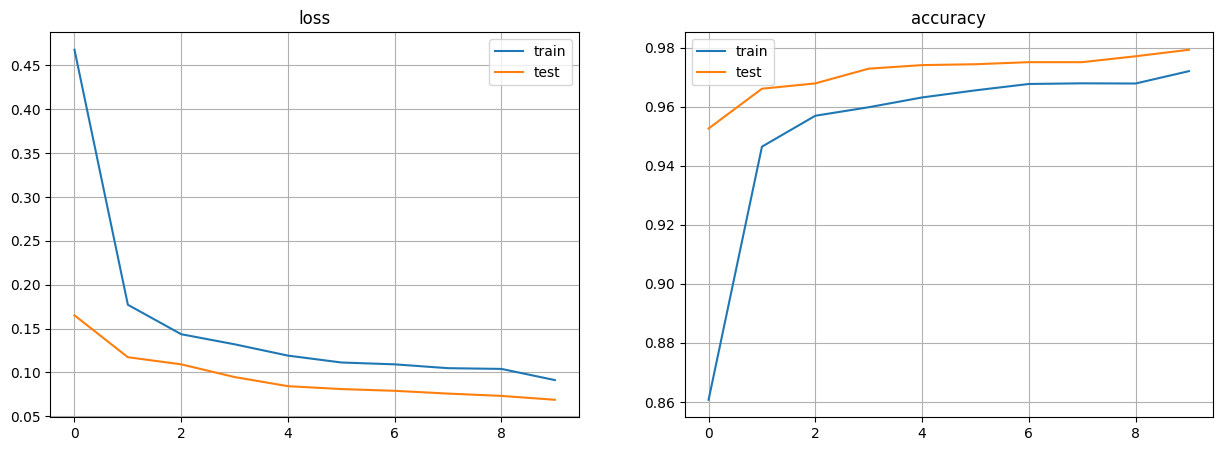

In [61]:
model = Mnist()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())
# optimizer = AdamW(model.parameters(), weight_decay=1e-1)

total_train_loss = []
total_test_loss = []
total_train_accuracy = []
total_test_accuracy = []

for epoch in range(10):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_dataloader)
    test_loss, test_accuracy = test(model, criterion, optimizer, test_dataloader)

    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)
    total_train_accuracy.append(train_accuracy)
    total_test_accuracy.append(test_accuracy)

    clear_output(True)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(total_train_loss, label='train')
    axs[0].plot(total_test_loss, label='test')
    axs[0].set_title('loss')
    axs[0].grid()
    axs[0].legend(loc='best')


    axs[1].plot(total_train_accuracy, label='train')
    axs[1].plot(total_test_accuracy, label='test')
    axs[1].set_title('accuracy')
    axs[1].grid()
    axs[1].legend(loc='best')

    plt.show()

In [62]:
print(f"Кол-во параметров: {sum(p.numel() for p in model.parameters())}.")

Кол-во параметров: 2870.
